# <a id='toc1_'></a>[05: Clustering users using KMeans and t-SNE](#toc0_)

The purpose is to cluster users according to their selling patterns using numerical data. This cluster assessment won't account for users preference for brands or product catalogs.

**Keywords**: k-means, clustering, users, sellers, Vinted

**Table of contents**<a id='toc0_'></a>    
- [Clustering users using KMeans and t-SNE](#toc1_)    
  - [Introduction](#toc1_1_)    
    - [K-Means](#toc1_1_1_)    
    - [Outliers](#toc1_1_2_)    
  - [Evaluation metrics](#toc1_2_)    
    - [Within-Cluster Sum of Squares](#toc1_2_1_)    
    - [Silhouette Scores](#toc1_2_2_)    
    - [Calinski-Harabasz Score](#toc1_2_3_)    
    - [Davies-Bouldin index](#toc1_2_4_)    
      - [Analysis of Clustering Metrics](#toc1_2_4_1_)    
  - [Analysis of the results](#toc1_3_)    
  - [Future Work](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [268]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

## <a id='toc1_1_'></a>[Introduction](#toc0_)

### <a id='toc1_1_1_'></a>[K-Means](#toc0_)

K-means clustering is a partitioning-based clustering algorithm that aims to group data points into distinct clusters based on their similarities.

The K-means algorithm operates iteratively to minimize the within-cluster variance, also known as inertia. It begins by randomly initializing cluster centroids and iteratively assigns each data point to the nearest centroid, updates the centroids based on the mean of the points assigned to each cluster, and repeats until convergence or a predefined stopping criterion is met.


**Key concepts**

- Centroids: Representative points of clusters that are updated iteratively during the algorithm's execution.
- Cluster Assignment: Determining which cluster each data point belongs to based on its proximity to the centroids.
- Inertia: Measure of the within-cluster variance, which K-means aims to minimize.
- Convergence: The point at which the algorithm stops iterating because the centroids no longer change significantly.

**Practical considerations**

- Initialization: The choice of initial centroids can significantly impact the clustering results. Random initialization and K-means++ are common approaches.
- Number of Clusters (K): Determining the optimal number of clusters can be challenging and often requires domain knowledge or heuristic methods such as the elbow method or silhouette analysis.

**Considerations**
- Remove outliers (outlier sensitive algorithm)
- Scale features (otherwise size different might affect results)
- Log norm skewed data (optional)
- Check for multicolinearity

In [269]:
def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return


load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

# Load a sample dataset
def load_data():
    engine = create_engine(aws_rds_url)
    sql_query = """
        SELECT t1.user_id, 
            COUNT(DISTINCT(t1.product_id)) as count_products, 
            SUM(t1.price_numeric) as sum_price, 
            AVG(t1.price_numeric) as avg_price, 
            AVG(t1.package_size_id) as avg_package_size, 
            SUM(t1.view_count) as total_views,
            AVG(t1.view_count) as avg_views,
            SUM(t1.favourite_count) as total_favourite,
            AVG(t1.favourite_count) as avg_favourite
        FROM public.tracking_staging  t1
        JOIN (
            SELECT product_id, MAX(date) AS latest_date
            FROM public.tracking_staging 
            GROUP BY product_id
        ) t2 ON t1.product_id = t2.product_id AND t1.date = t2.latest_date
        GROUP BY user_id
    """
    #sql_query = "select * from public.tracking_staging limit 100"
    df = pd.read_sql(sql_query, engine)
    return (df)

data = load_data()
print(f"The dataframe has {len(data)} columns")
data.head(5)

The dataframe has 1353 columns


,user_id,count_products,sum_price,avg_price,avg_package_size,total_views,avg_views,total_favourite,avg_favourite
0,126937.0,34,118,3.470588,1.000000,524,15.411765,86,2.529412
1,184881.0,15,153,10.200000,1.000000,586,39.066667,108,7.200000
2,278357.0,46,930,20.217391,2.152174,2439,53.021739,311,6.760870
3,284071.0,18,285,15.833333,1.500000,1322,73.444444,101,5.611111
4,458357.0,72,403,5.597222,1.208333,1546,21.472222,101,1.402778


The query selects the latest records for each product_id, so that no product_id has duplicate values.
For each user, we compute a number of statistics regarding their product portfolios, such as:

- average article price
- number of products
- total volume on sale
- average article size
- total views of portfolio
- average views per product
- average favourites
- total favourites

There are missing users, I'm not sure why.

In [270]:
data = data.dropna()
print(f"The dataframe has {len(data)} columns")

The dataframe has 1352 columns


In [271]:
fig = go.Figure()

cols = ["count_products", "sum_price", "avg_price", "avg_package_size", "total_views", "total_favourite", "avg_views", "avg_favourite"]

for col in cols:
    fig.add_trace(go.Violin(y=data[col],
                            name=col,
                            box_visible=True,
                            meanline_visible=True))
    
fig

In [272]:
data.skew()

user_id              0.548746
count_products       5.397245
sum_price            6.068463
avg_price            5.184020
avg_package_size     1.142009
total_views          4.515716
avg_views            3.453344
total_favourite     12.011269
avg_favourite        6.584297
dtype: float64

In [273]:
data.drop("user_id", axis = 1).describe()

,count_products,sum_price,avg_price,avg_package_size,total_views,avg_views,total_favourite,avg_favourite
count,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000
mean,49.065828,876.857988,26.302894,1.519413,1624.228550,43.931965,206.551775,4.135563
std,66.444253,1615.997585,39.103039,0.472834,2476.018715,49.701470,739.479585,6.397491
min,1.000000,3.000000,1.258621,1.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,195.000000,6.862929,1.133333,387.750000,16.024432,31.750000,1.365909
50%,35.000000,403.000000,14.000000,1.400000,905.500000,28.832143,74.500000,2.378061
75%,59.000000,874.250000,29.112847,1.800000,1853.500000,51.623580,161.000000,4.574026
max,943.000000,25274.000000,539.518519,3.250000,25142.000000,476.050000,14178.000000,95.946429


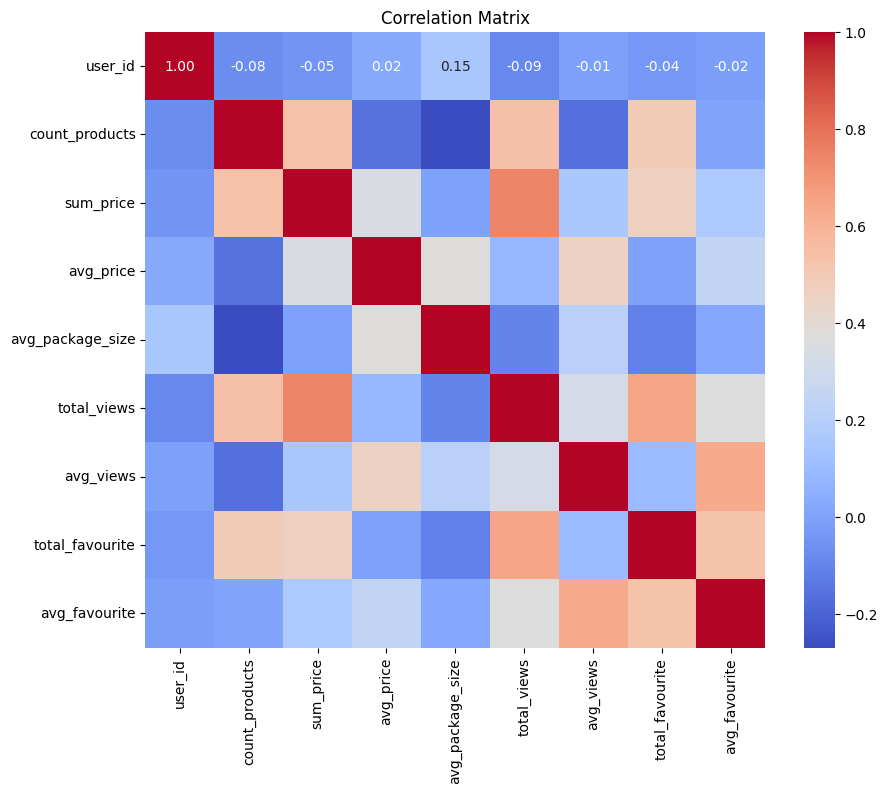

In [274]:
corr_matrix = data.corr()

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### <a id='toc1_1_2_'></a>[Outliers](#toc0_)

We detect a specially right skewed data (long positive tail) for the features "sum_price", "total_views" and "total_favourite", so It's smart to apply a small preprocessing step to remove outliers.

> Outliers can impact distance based algorithms such as K-Means

Outliers can significantly distort these distance measures, since they rely on distances leading to suboptimal cluster assignments.

> Outliers can skew the centroids or centers of clusters, making them less representative of the majority of data points within the cluster.

> Outliers can impact cluster cohesion and separations through clustering metrics (such WCSS)

Outliers may artificially increase the within-cluster variance and decrease the between-cluster variance, leading to less distinct and meaningful clusters

In [275]:
"""
# Select columns to remove outliers from
columns_to_remove_outliers = ["sum_price", "total_views", "total_favourite", "avg_price", "avg_favourite", "count_products"]

# Compute Z-score for selected columns
scaler = StandardScaler()
df_zscore = data.copy()
df_zscore[columns_to_remove_outliers] = scaler.fit_transform(df_zscore[columns_to_remove_outliers])

# Define threshold for Z-score
threshold = 3

# Filter out rows with Z-score greater than threshold
df_filtered = df_zscore[(np.abs(df_zscore[columns_to_remove_outliers]) < threshold).all(axis=1)]

# Convert back to original scale
df_filtered[columns_to_remove_outliers] = scaler.inverse_transform(df_filtered[columns_to_remove_outliers])
data = df_filtered
data.head(5)
"""


'\n# Select columns to remove outliers from\ncolumns_to_remove_outliers = ["sum_price", "total_views", "total_favourite", "avg_price", "avg_favourite", "count_products"]\n\n# Compute Z-score for selected columns\nscaler = StandardScaler()\ndf_zscore = data.copy()\ndf_zscore[columns_to_remove_outliers] = scaler.fit_transform(df_zscore[columns_to_remove_outliers])\n\n# Define threshold for Z-score\nthreshold = 3\n\n# Filter out rows with Z-score greater than threshold\ndf_filtered = df_zscore[(np.abs(df_zscore[columns_to_remove_outliers]) < threshold).all(axis=1)]\n\n# Convert back to original scale\ndf_filtered[columns_to_remove_outliers] = scaler.inverse_transform(df_filtered[columns_to_remove_outliers])\ndata = df_filtered\ndata.head(5)\n'

I was wondering why the preprocessing was actually hurting the algorithm. After some search I realize I was doing it wrong. The preprocessing should be made at granular level, not aggregate level. For instance, I should be removing products with high prices, not customers that sell products at high prices in general. There can be a meaning behind it. For example, sellers that do not mind to wait weeks or months to make sales vs sellers who want to sell the items fast have different pricing strategies.

Removing this data and labelling it as noise was removing some interesting aspects to the data.

In [276]:
for col in data.columns:
    data[col] = MinMaxScaler().fit_transform(X = data[[col]])
data.head(5)

,user_id,count_products,sum_price,avg_price,avg_package_size,total_views,avg_views,total_favourite,avg_favourite
0,0.000000,0.035032,0.004551,0.004109,0.000000,0.020842,0.032374,0.006066,0.026363
1,0.000290,0.014862,0.005936,0.016612,0.000000,0.023308,0.082064,0.007617,0.075042
2,0.000758,0.047771,0.036682,0.035222,0.512077,0.097009,0.111379,0.021935,0.070465
3,0.000786,0.018047,0.011159,0.027077,0.222222,0.052581,0.154279,0.007124,0.058482
4,0.001659,0.075372,0.015828,0.008060,0.092593,0.061491,0.045105,0.007124,0.014620


## <a id='toc1_2_'></a>[Evaluation metrics](#toc0_)

### <a id='toc1_2_1_'></a>[Within-Cluster Sum of Squares](#toc0_)

It is a metric used to evaluate the quality of clustering in unsupervised learning algorithms like K-means. WCSS measures the compactness of clusters by calculating the sum of squared distances between each data point in a cluster and the centroid of that cluster.

$WCSS = \sum_{i=1}^{K} \sum_{x \in C_i} \left\lVert x - \mu_i \right\rVert^2$

### <a id='toc1_2_2_'></a>[Silhouette Scores](#toc0_)

Silhouette score is a metric used to evaluate the quality of clustering. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette score ranges from -1 to 1, where:

- A score close to +1 indicates that the data point is well-clustered and is far away from neighboring clusters.
- A score close to 0 indicates that the data point is close to the decision boundary between two neighboring clusters.
- A score close to -1 indicates that the data point may have been assigned to the wrong cluster.

- A **higher** silhouette score indicates better clustering.

### <a id='toc1_2_3_'></a>[Calinski-Harabasz Score](#toc0_)

The Calinski-Harabasz score, also known as the Variance Ratio Criterion, is a metric used to evaluate the quality of clustering in unsupervised learning algorithms. It measures the ratio of between-cluster dispersion to within-cluster dispersion.

- A **higher** Calinski-Harabasz score indicates better clustering, with tighter and more well-separated clusters.

### <a id='toc1_2_4_'></a>[Davies-Bouldin index](#toc0_)

It measures the average similarity between each cluster and its most similar cluster, where similarity is defined based on the ratio of within-cluster scatter to between-cluster separation.

- A **lower** Davies-Bouldin index indicates better clustering, with clusters that are more distinct and well-separated.

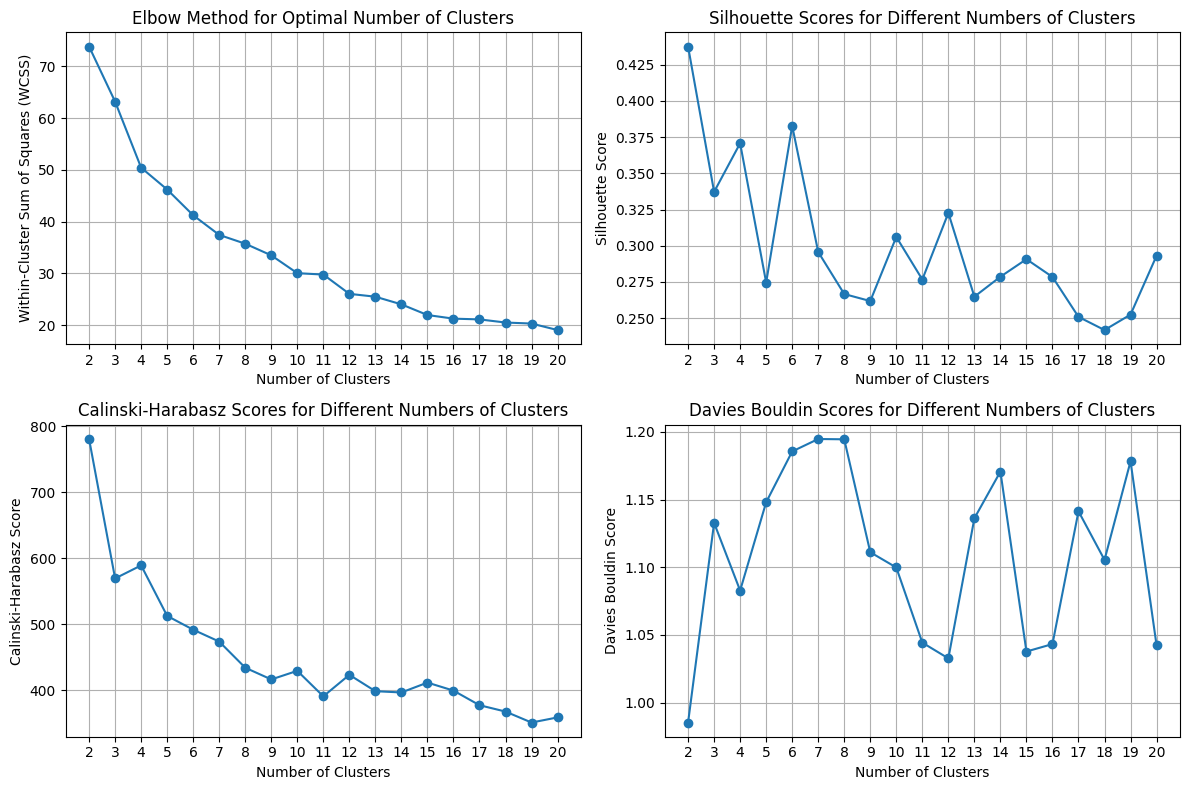

In [277]:
k_range = range(2, 21)

# Initialize lists to store evaluation metrics
wcss = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

# Loop over the range of clusters
for k in k_range:
    # Initialize KMeans object
    kmeans = KMeans(n_clusters=k,
                    algorithm= "elkan",
                    max_iter= 500)
    # Fit KMeans to the data
    kmeans.fit(data.drop(["user_id"], axis=1))
    # Append the value of WCSS to the list
    wcss.append(kmeans.inertia_)
    # Compute silhouette score
    silhouette_avg = silhouette_score(data.drop(["user_id"], axis=1), kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    # Compute Calinski-Harabasz score
    calinski_score = calinski_harabasz_score(data.drop(["user_id"], axis=1), kmeans.labels_)
    calinski_scores.append(calinski_score)
    # Compute Calinski-Harabasz score
    davies_bouldin = davies_bouldin_score(data.drop(["user_id"], axis=1), kmeans.labels_)
    davies_bouldin_scores.append(davies_bouldin)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot the elbow curve
axes[0, 0].plot(k_range, wcss, marker='o', linestyle='-')
axes[0, 0].set_title('Elbow Method for Optimal Number of Clusters')
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')
axes[0, 0].set_xticks(k_range)
axes[0, 0].grid(True)

# Plot silhouette scores
axes[0, 1].plot(k_range, silhouette_scores, marker='o', linestyle='-')
axes[0, 1].set_title('Silhouette Scores for Different Numbers of Clusters')
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_xticks(k_range)
axes[0, 1].grid(True)

# Plot Calinski-Harabasz scores
axes[1, 0].plot(k_range, calinski_scores, marker='o', linestyle='-')
axes[1, 0].set_title('Calinski-Harabasz Scores for Different Numbers of Clusters')
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_xticks(k_range)
axes[1, 0].grid(True)

# Plot Calinski-Harabasz scores
axes[1, 1].plot(k_range, davies_bouldin_scores, marker='o', linestyle='-')
axes[1, 1].set_title('Davies Bouldin Scores for Different Numbers of Clusters')
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].set_ylabel('Davies Bouldin Score')
axes[1, 1].set_xticks(k_range)
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

### <a id='toc1_2_4_1_'></a>[Analysis of Clustering Metrics](#toc0_)

- The WCSS method suggests the number of clusters 7 is the inflexion point
- Silhouette scores, which measure how similar an object is to its own cluster compared to other clusters, also suggest that 7 clusters yield higher values closer to 1, indicating better cluster quality.
- The Calinski-Harabasz (CH) index, which evaluates cluster validity based on between-cluster dispersion and within-cluster dispersion, shows a peak at 7, suggesting strong cluster structure at this point.
- While the Davies-Bouldin index is minimized at both 5 and 7 clusters, the consistency with the other metrics supports the choice of 5 or 7 clusters as a viable option.

Based on several clustering metrics, it appears that the optimal number of clusters for the dataset is around 7.

In [278]:
kmeans = KMeans(n_clusters=5,
                algorithm= "elkan",
                max_iter= 500)
kmeans.fit(data.drop(["user_id"], axis= 1))
data["labels"] = kmeans.labels_
data.head(5)

,user_id,count_products,sum_price,avg_price,avg_package_size,total_views,avg_views,total_favourite,avg_favourite,labels
0,0.000000,0.035032,0.004551,0.004109,0.000000,0.020842,0.032374,0.006066,0.026363,0
1,0.000290,0.014862,0.005936,0.016612,0.000000,0.023308,0.082064,0.007617,0.075042,0
2,0.000758,0.047771,0.036682,0.035222,0.512077,0.097009,0.111379,0.021935,0.070465,4
3,0.000786,0.018047,0.011159,0.027077,0.222222,0.052581,0.154279,0.007124,0.058482,4
4,0.001659,0.075372,0.015828,0.008060,0.092593,0.061491,0.045105,0.007124,0.014620,0


In [279]:
# Compute t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X_tsne = tsne.fit_transform(data.drop(["user_id", "labels"], axis = 1))

pca_df = pd.DataFrame(data=X_tsne, 
                      columns=['PC1', 'PC2'], 
                      index = data.index)

concat_df = pd.concat([pca_df, 
                       data], 
                      ignore_index= False, 
                      axis=1)

concat_df = concat_df.rename(columns={0: 'Cluster'})
concat_df.index = concat_df.index.astype("category")
print(concat_df.index.dtype)

fig = px.scatter(concat_df, x='PC1', y='PC2', color='labels', title='t-SNE Plot')
fig

category


In [280]:
# Calculate the percentages
df_style = data.groupby("labels")["user_id"].count() / data.groupby("labels")["user_id"].count().sum()

# Function to format values as percentages with 2 decimals
def format_percentage(value):
    return '{:.2%}'.format(value)

# Apply formatting function and styling
styled_data = df_style.reset_index(name="count").apply(lambda x: format_percentage(x['count']), axis=1).reset_index(drop=True).to_frame()
styled_data.columns = ['count']
styled_data.style.set_caption('Percentage of User IDs by Cluster label')
styled_data

,count
0,53.03%
1,8.51%
2,3.92%
3,2.22%
4,32.32%


In [281]:
# Aggregate mean values for each label across different features
radar_data = []
for label in data["labels"].unique():
    label_data = data[data["labels"] == label].drop(["user_id", "labels"], axis=1).mean() * 100
    radar_data.append(label_data)

# Define feature names
feature_names = radar_data[0].index.tolist()

# Create traces for radar chart
traces = []
for i, label_data in enumerate(radar_data):
    trace = go.Scatterpolar(
        r=label_data.values,
        theta=feature_names,
        fill='toself',
        name=f'Label {i}'
    )
    traces.append(trace)

# Define layout
layout = go.Layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]  # Adjust the range as needed
        )
    ),
    showlegend=True
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show plot
fig.show()

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Miguel\AppD

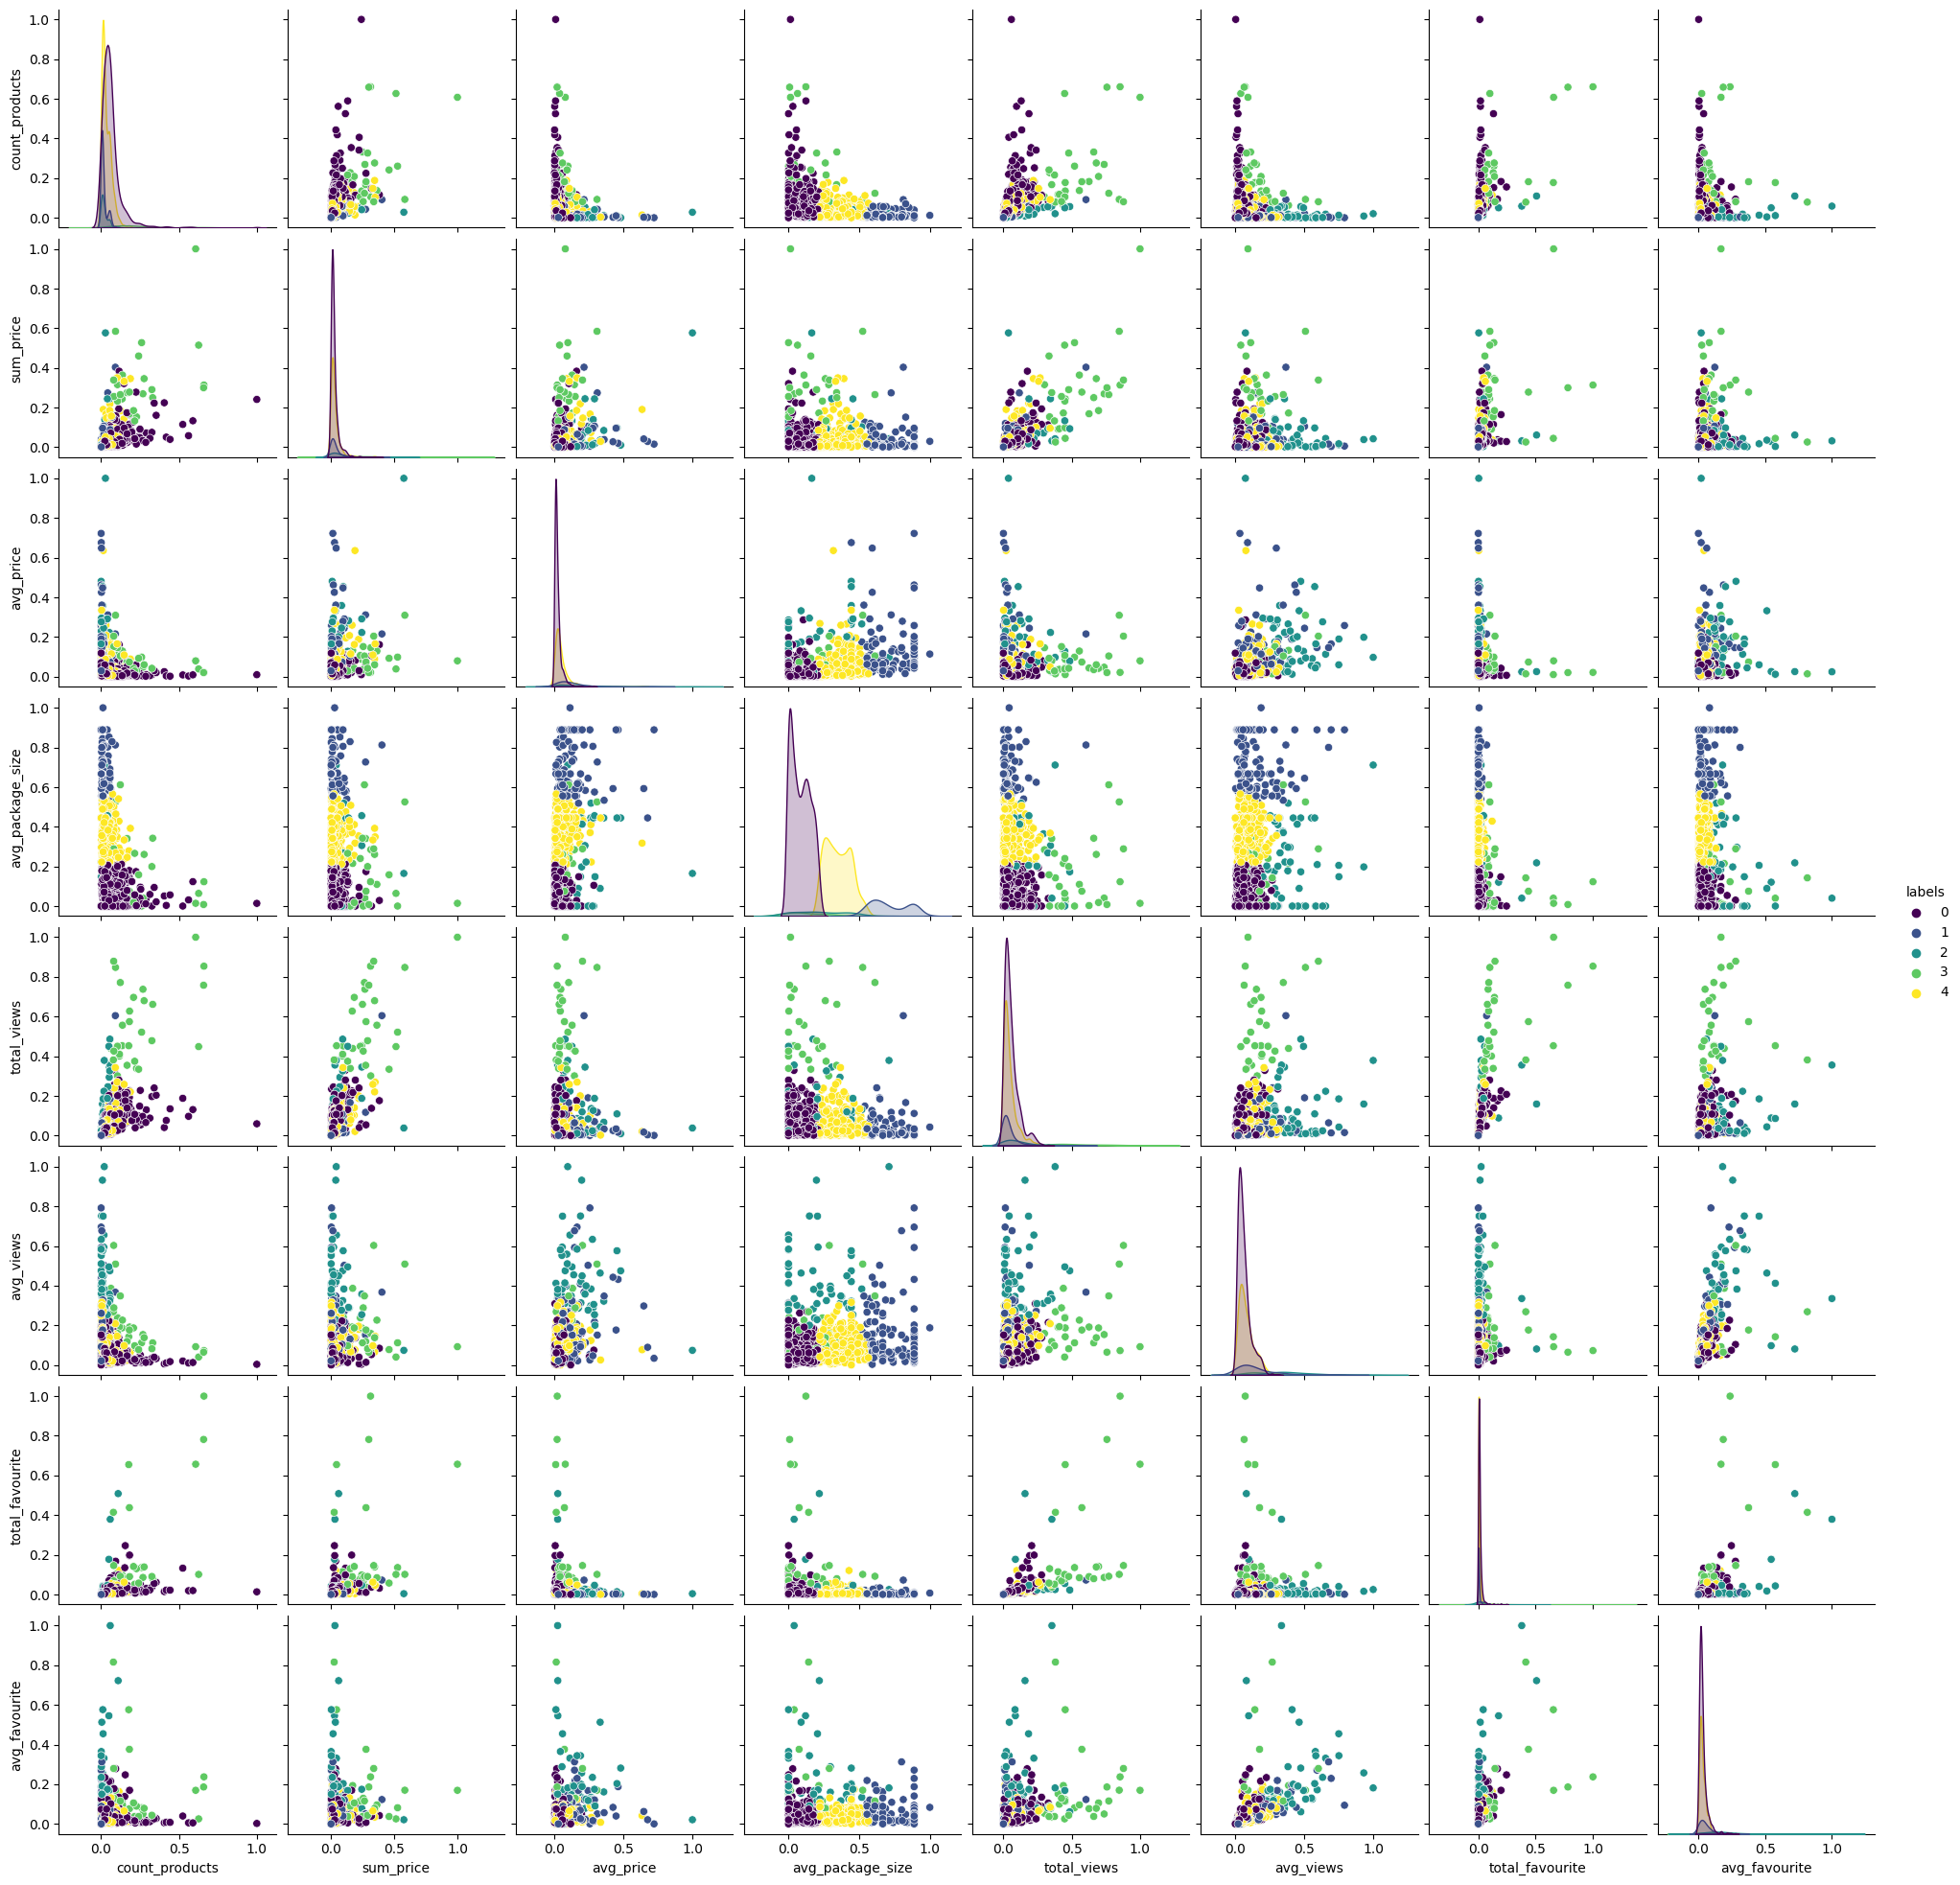

In [282]:
columns = ['count_products', 'sum_price', 'avg_price', 
           'avg_package_size', 
           'total_views', 'avg_views', 'total_favourite', 'avg_favourite', 
           'labels']

# Create a pairplot
sns.pairplot(data[columns], hue='labels', palette='viridis')

## <a id='toc1_3_'></a>[Analysis of the results](#toc0_)

- Total views group - **the most viewed**: this group has the largest total views of any group.
It also has the largest total volume in articles but just by a short margin.


Its about 6% of total users

- Package size cluster - **the big assets**: this group transactions products which are in average, bigger than the other groups by a large margin.


About 9% of total users.

- The very balanced group (hard to see) - **the casuals**: it is the most well rounded group, with some variety in products (catalogs, brands and sizes) but not much. They are characterized by having the smallest count products of any group.


It is about 29% of the total users.

- The group which transacts more items (by far) - **the big sellers**: this is the group that has more items on display. They tend to have a lot of items and items of different brands and catalogs.


About 27% of total users.

- The group with more average views - **the premium sellers**: this group transacts premium articles. Their articles last longer and gather more views than their counterparts. Their average price is the highest of any group.


About 21% of total users.

## <a id='toc1_4_'></a>[Future Work](#toc0_)

K-Means algorithm is raising robustness issues. Every iteration seems to result in different clusters, which makes me realize some measures must be in place to achieve robust results.

